In [1]:
import pandas as pd
from src import (
    drop_first_column,
    rename,
    fill_nan_values,
    joint_plot_pearson,
    scatters,
    boxes,
    count_purposes,
    remove_skewness,
    distributions,
    scale_features,
    plot_inertias,
    plot_pivot)
import warnings
from src.model_evaluator.cluster_model import best_silhouette_score, clusters_range_evaluation, get_clustered_data
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('/Users/gscerberus/Desktop/German_Bank_Customer_Segmentation')

In [3]:
import os
os.chdir('/Users/gscerberus/Desktop/German_Bank_Customer_Segmentation')

In [4]:
df = pd.read_csv('data/german_credit_data.csv')

In [5]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [6]:
# dropping first column
df = drop_first_column(df, 'Unnamed: 0')

In [7]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [9]:
fill_nan_values(df, 'Saving accounts')
fill_nan_values(df, 'Checking account')

In [10]:
# rename column Credit amount
df = rename(df, 'Credit amount')

In [12]:
# Selecting columns for clustering with k-means
selected_cols = ['Credit_amount', 'Duration', 'Age']

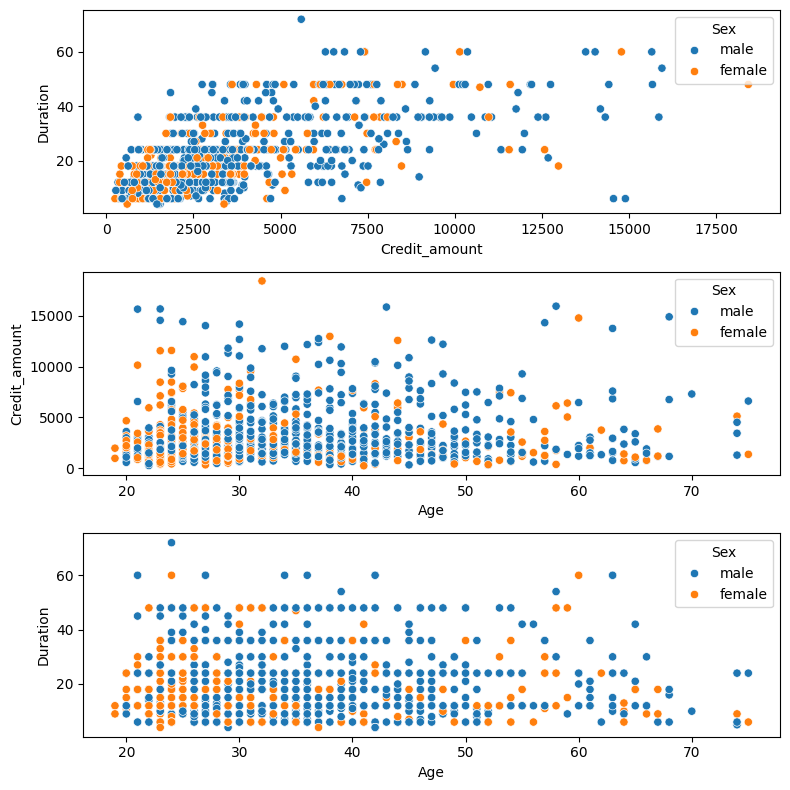

In [14]:
# visualizing scatters
scatters(df, cols = selected_cols, h = 'Sex')

By the plots above, we can see there is no significat difference between men and women in terms of getting credit.

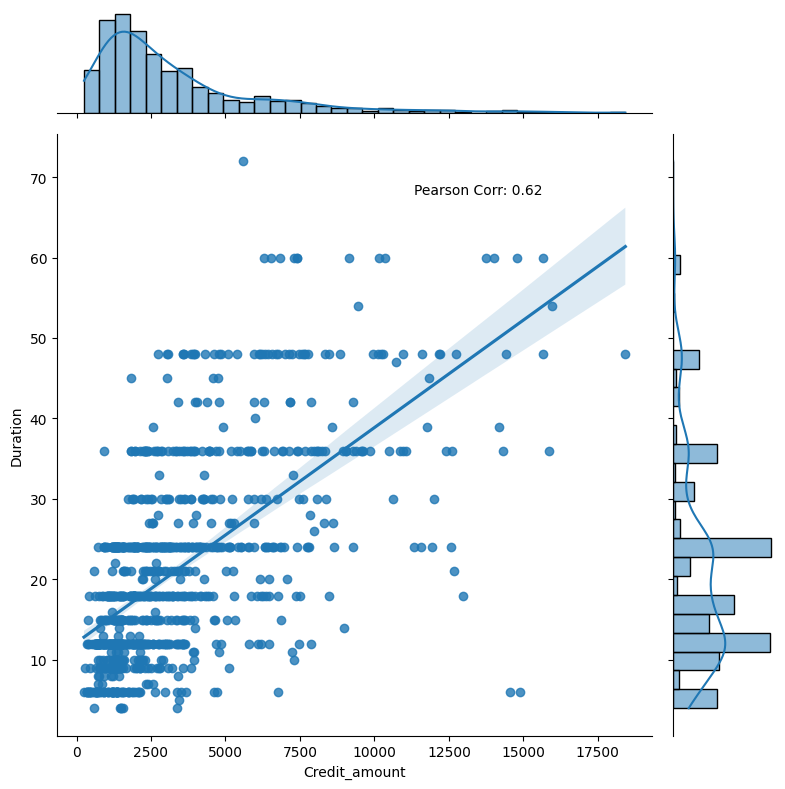

In [15]:
joint_plot_pearson(df, x = 'Credit_amount', y = 'Duration')

The value of pearson coefficient is not only positive, but also high enough to show there is a relationship between Credit amount and Duration. This makes sense, since people tend to take higher credit amounts for longer periods of time.

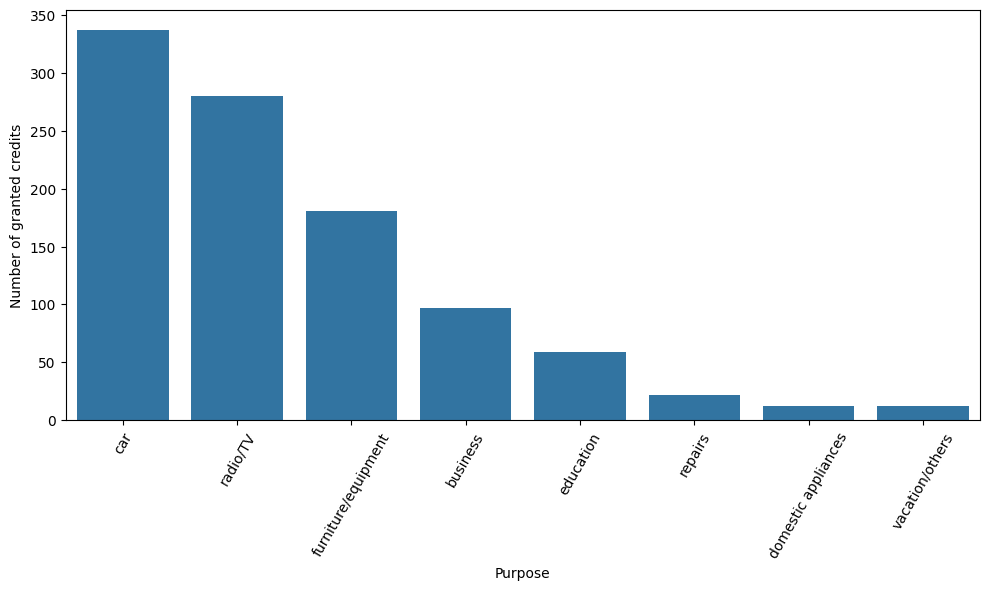

In [18]:
count_purposes(df, x = 'Purpose', group_col='Age')

Most of the credits were granted for car and ratio/TV.

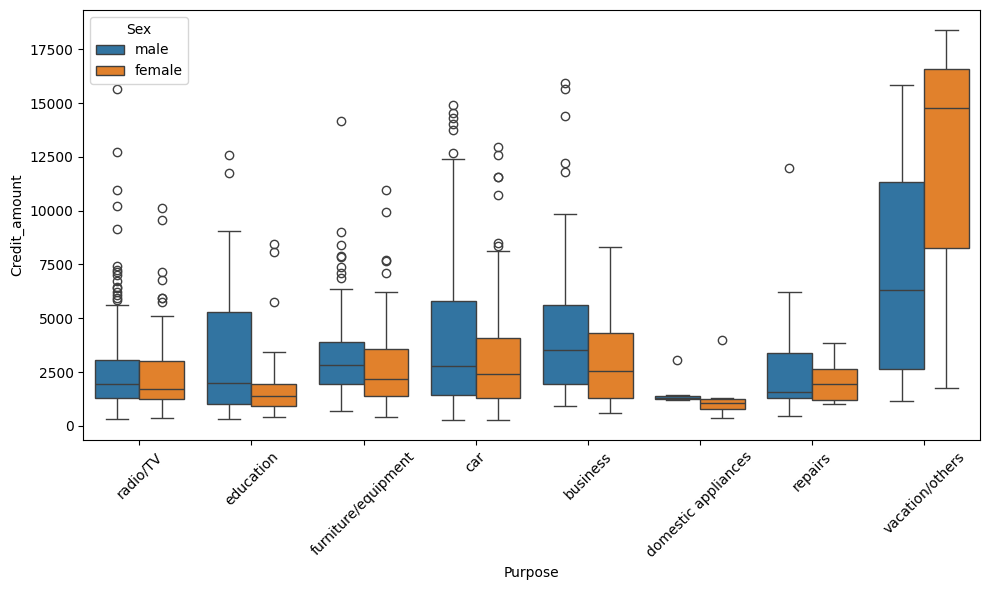

In [19]:
boxes(df, x = 'Purpose', y = 'Credit_amount', h = 'Sex') #1

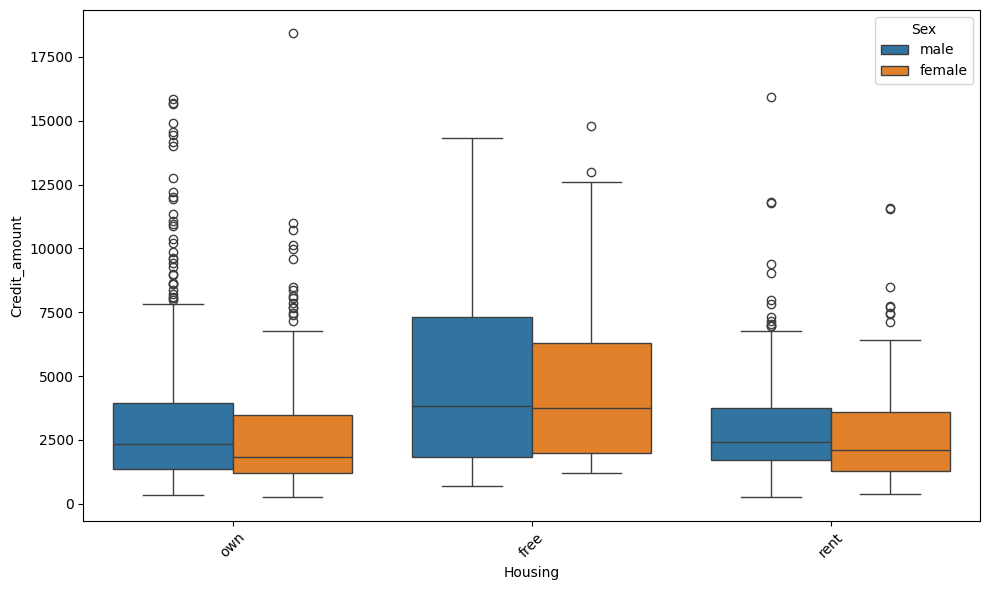

In [20]:
boxes(df, x = 'Housing', y = 'Credit_amount', h = 'Sex') #2

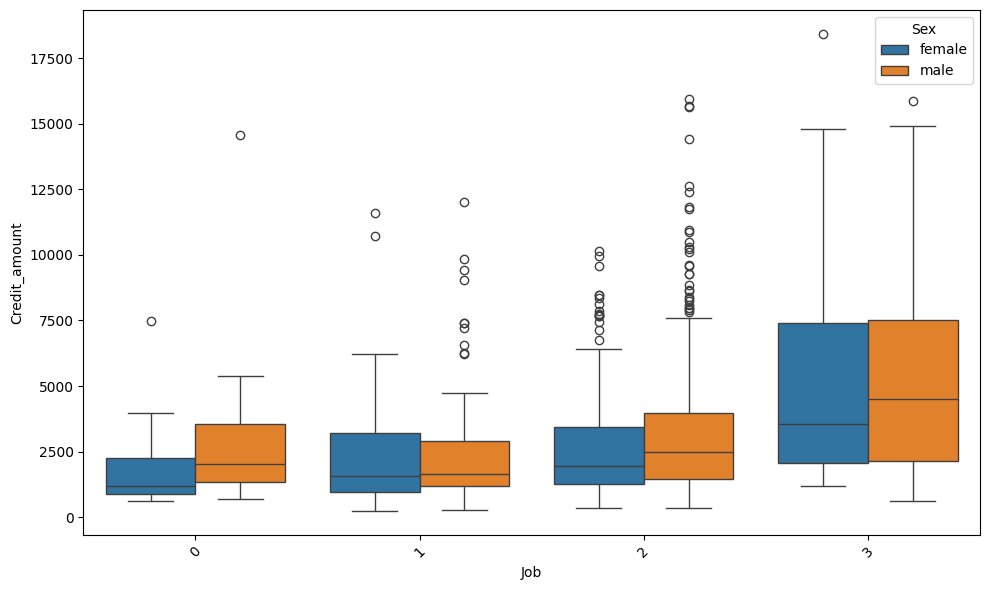

In [21]:
boxes(df, x = 'Job', y = 'Credit_amount', h = 'Sex') #3

Boxplots drawn above, show us that there is no difference in terms of sex, about credit amount. What we can note however is that free housing, tends more to get credits and apparently job 3 takes more credit than other jobs.

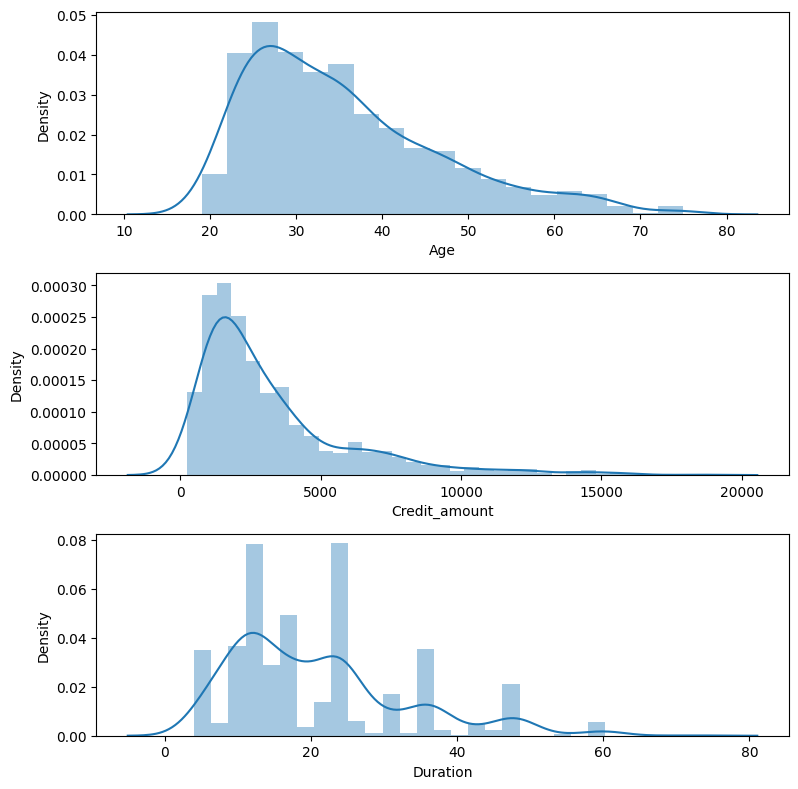

In [22]:
distributions(df, cols = selected_cols)

We will get a new df to work with, consisting only on those 3 columns and at the same time we will apply the method remove_skewness to remove the skewness of our features distributions.

In [23]:
final_df = df[selected_cols]

final_df

,Credit_amount,Duration,Age
0,1169,6,67
1,5951,48,22
2,2096,12,49
3,7882,42,45
4,4870,24,53
...,...,...,...
995,1736,12,31
996,3857,30,40
997,804,12,38
998,1845,45,23


In [24]:
# the newly created dataframe
final_df = remove_skewness(final_df, selected_cols)

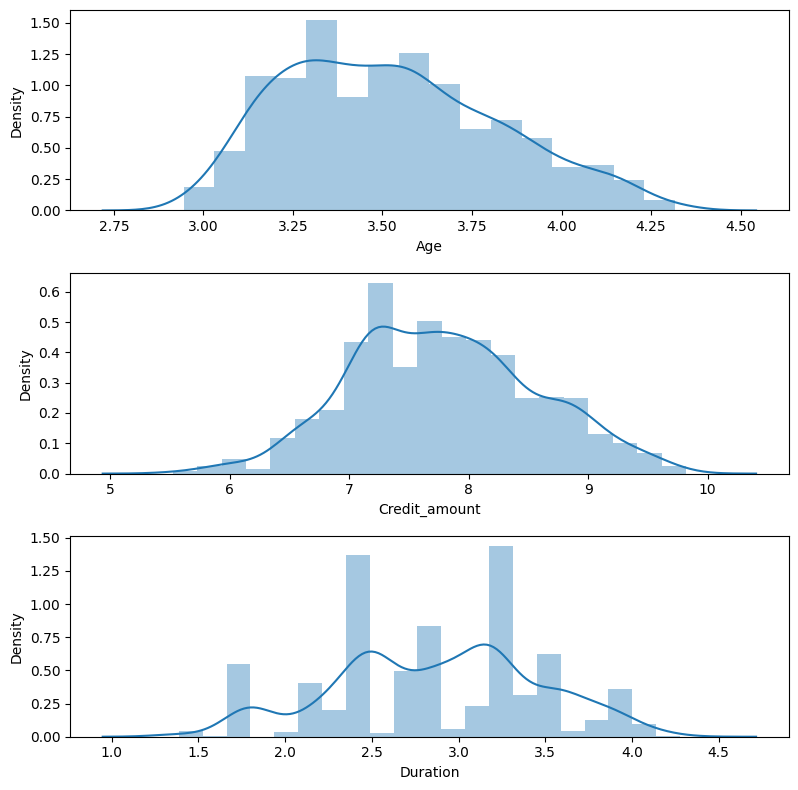

In [25]:
distributions(final_df, selected_cols)

In [26]:
final_df = scale_features(final_df)

In [27]:
final_df.head()

,Credit_amount,Duration,Age
0,-0.933901,-1.864869,2.271006
1,1.163046,1.708369,-1.446152
2,-0.181559,-0.673790,1.226696
3,1.525148,1.478913,0.942455
4,0.904743,0.517289,1.488620


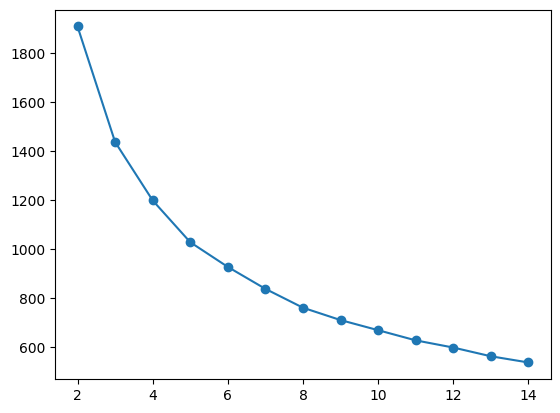

In [28]:
# show results of different cluster ranges
clusters_range = range(2,15)
random_seed = range(0,20)

inertias = clusters_range_evaluation(clusters_range, final_df)

plot_inertias(clusters_range, inertias)

We see from the plot that the inertia decreases as the number of clusters increases, and this is good, but the ideal scenario would be to have a low inertia while maintaining a low number of clusters as well. On the other hand we should aim for a number of clusters indicating a maximized <b>silhouette score </b>. The silhouette score is a useful metric for evaluating the quality of clusters in K-means clustering, and it can help us determine the optimal number of clusters.

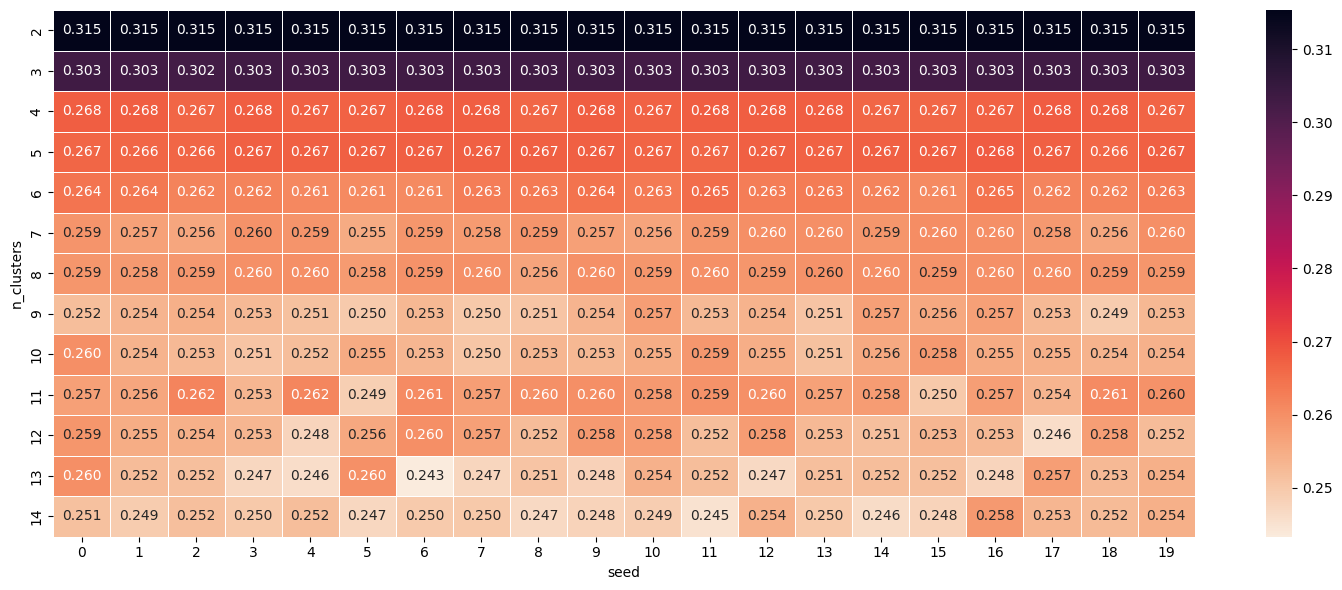

In [29]:
pivot_table = best_silhouette_score(clusters_range, random_seed, final_df)

plot_pivot(pivot_table)

The highest scores are for 2 and 3 clusters and they are relatively insensitive to seed.

In [30]:
# Changes made to the initial dataframe
df = df[selected_cols]

df_clustered = get_clustered_data(n_clusters=3, random_state=19, data_scaled = final_df, initial_data=df)

In [31]:
df_clustered

,Credit_amount,Duration,Age,Cluster
0,1169,6,67,2
1,5951,48,22,0
2,2096,12,49,2
3,7882,42,45,0
4,4870,24,53,0
...,...,...,...,...
995,1736,12,31,1
996,3857,30,40,0
997,804,12,38,2
998,1845,45,23,0


Let's test the predictions, using scatter plots.

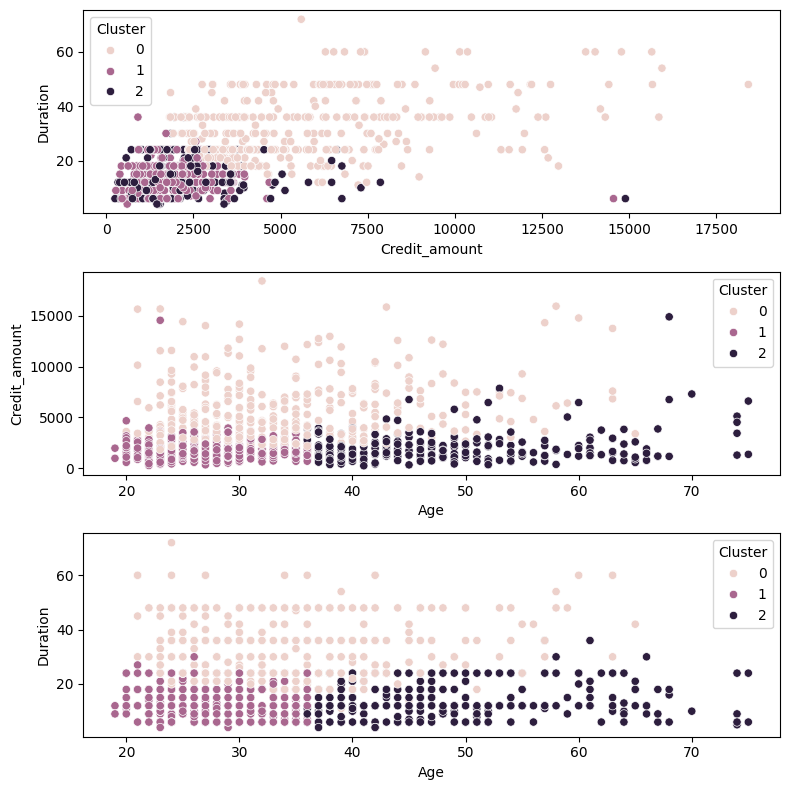

In [32]:
scatters(data=df_clustered, cols = selected_cols, h='Cluster')

Since KMeans models are lightweight and easy to retrain, we will create a pickle file storing only the metrics, so the inertia and silhouette score results.

In [33]:
silhouette_scores = pivot_table.values
# inertias = clusters_range_evaluation(clusters_range, final_df)

In [34]:
# Convert df to csv to later use it in fastapi
df.to_csv('german_credit_data_updated.csv', index=False)